# Flujo de Modelado de Series de Tiempo: Facturación y Saldo

Este notebook implementa un flujo completo para el análisis, modelado y predicción de series de tiempo multivariadas enfocadas en los cambios porcentuales de **facturación** y **saldo**. Se incluyen tres familias de modelos (**Ridge**, **SARIMAX** y **Prophet**) y un cuarto modelo de tipo **ensemble**.

A continuación se describen los pasos del proceso:

---

## 1. Carga y preparación de datos
- Se combinan las fuentes de datos `macros` y `base` usando la columna **Fecha** como índice.
- Se asegura que el índice sea de tipo fecha y esté ordenado cronológicamente.
- Se generan las variables **target** como los cambios porcentuales (`pct_change`) de `facturacion` y `saldo`.  
  Esto permite modelar variaciones relativas en lugar de valores absolutos.

---

## 2. Definición de features y targets
- **Features**: todas las variables predictoras excepto `facturacion`, `saldo`, `facturacion_change` y `saldo_change`.
- **Targets**: `facturacion_change` y `saldo_change`.
- Se eliminan filas con valores nulos para garantizar consistencia en el entrenamiento.

---

## 3. Escalado de datos
- **Features**: normalización con `StandardScaler` para estabilizar magnitudes y evitar dominancia de variables.
- **Targets**: reescalado con `MinMaxScaler` a [0,1] para mejorar la estabilidad en el entrenamiento.

---

## 4. Validación cruzada temporal
- Se usa `TimeSeriesSplit` con 3 divisiones para respetar el orden cronológico y evaluar el desempeño de los modelos sin fuga de datos futuros.

---

## 5. Función genérica de evaluación
- Calcula el **RMSE (Root Mean Squared Error)** en cada fold de validación y reporta la **mediana** de los errores como métrica de desempeño.

---

## 6. Modelos evaluados

### a. Ridge Regression
- Modelo lineal penalizado (regularización L2).
- Captura relaciones lineales mientras controla el sobreajuste.

### b. SARIMAX
- Modelo autorregresivo integrado con medias móviles y regresores exógenos.
- Capaz de modelar dependencias temporales y efectos de variables externas.

### c. Prophet
- Modelo aditivo diseñado para series con tendencias y estacionalidades.
- Se añaden las features como regresores externos.

---

## 7. Optimización de hiperparámetros con Optuna
Para mejorar el rendimiento, se plantea incluir **Optuna**, una biblioteca de optimización bayesiana de hiperparámetros.  
Optuna explora automáticamente el espacio de búsqueda de parámetros con un enfoque secuencial e inteligente.

### Parámetros a optimizar:

**Ridge Regression**
- `alpha`: controla el grado de regularización L2.  
  - **Fundamento**: valores altos reducen el sobreajuste pero pueden sesgar el modelo.

**SARIMAX**
- `p`, `d`, `q`: términos autorregresivos, diferenciales y de medias móviles.  
  - **Fundamento**: definen la dinámica temporal.
- `seasonal_order`: si hay estacionalidad.  
  - **Fundamento**: ayuda a capturar patrones cíclicos relevantes.

**Prophet**
- `changepoint_prior_scale`: controla la flexibilidad para detectar cambios de tendencia.  
  - **Fundamento**: valores altos permiten cambios rápidos en la tendencia.
- `seasonality_prior_scale`: controla la influencia de los componentes estacionales.  
  - **Fundamento**: regula la complejidad de los ciclos anuales, semanales, etc.

---

## 8. Comparación de modelos
- Se comparan los RMSE de cada modelo para **facturación** y **saldo**.
- Se selecciona el mejor modelo (menor RMSE) y se muestran tablas y gráficos comparativos.

---

## 9. Resultados por fold
- Además del RMSE por mediana, se guardan los RMSE individuales por fold para el mejor modelo de cada target.
- Esto permite entender la estabilidad y variabilidad del desempeño en los diferentes periodos.

---

## 10. Entrenamiento final con todo el histórico
- El mejor modelo para cada target se reentrena usando todo el histórico disponible.
- Con este modelo final se obtienen predicciones para los datos históricos (backtest).

---

## 11. Predicciones históricas para todas las familias
- Se generan predicciones históricas para **Ridge**, **SARIMAX** y **Prophet** usando todos los datos.
- Se grafican junto con los valores reales para evaluar visualmente su ajuste.

---

## 12. Ensemble de modelos
- Se crea un **modelo ensemble simple** combinando las predicciones (promedio) de las tres familias de modelos.
- Este enfoque busca capturar la fortaleza de cada modelo y reducir el error por complementariedad.

---



In [1]:
def clean_value(x):
    if isinstance(x, str):
        x = x.replace('%', '').replace('$', '').replace(',', '')
        x = x.replace(' ', '')
    try:
        return float(x)
    except:
        return None
    
def plot_escenarios(df, variable):
    escenarios = [col for col in df.columns if col.startswith(variable)]
    
    plt.figure(figsize=(10, 6))
    for col in escenarios:
        plt.plot(df['Fecha'], df[col], label=col)
    
    plt.title(variable)
    plt.legend(loc="upper left", fontsize='x-small')
    plt.grid(True)
    plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Ruta del archivo
ruta = r"C:\Users\ASUS\Documents\GitHub\tuya\BASE_DS.xlsx"

# Cargar BASE
base = pd.read_excel(ruta, sheet_name="BASE")
base = base[["Fecha", "facturacion", "saldo"]]

# Cargar MACROS
macros = pd.read_excel(ruta, sheet_name="MACROS")
# macros.columns = macros.columns.str.strip()
macros.columns = (
    macros.columns
    .str.replace('\n', ' ', regex=True)  # Reemplaza saltos de línea por espacio
    .str.replace('\s+', ' ', regex=True) # Colapsa espacios múltiples en uno solo
    .str.strip()                          # Quita espacios al inicio y fin
)
# Apply cleaning to all except the first column (Fecha)
for col in macros.columns[1:]:
    macros[col] = macros[col].apply(clean_value)

# Convertir fecha 
macros['Fecha'] = pd.to_datetime(macros['Fecha'], format="%b-%y", errors='coerce')


# Convertir fecha 
base['Fecha'] = pd.to_datetime(base['Fecha'], format="%b-%y", errors='coerce')
base.set_index('Fecha', inplace=True)


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\

Resultados Facturación:
      Model      RMSE
0    Ridge  0.269790
1  SARIMAX  0.515133
2  Prophet  2.513016

Resultados Saldo:
      Model      RMSE
0    Ridge  0.242055
1  SARIMAX  0.418305
2  Prophet  1.146715

Mejor modelo Facturación: Ridge
Mejor modelo Saldo: Ridge


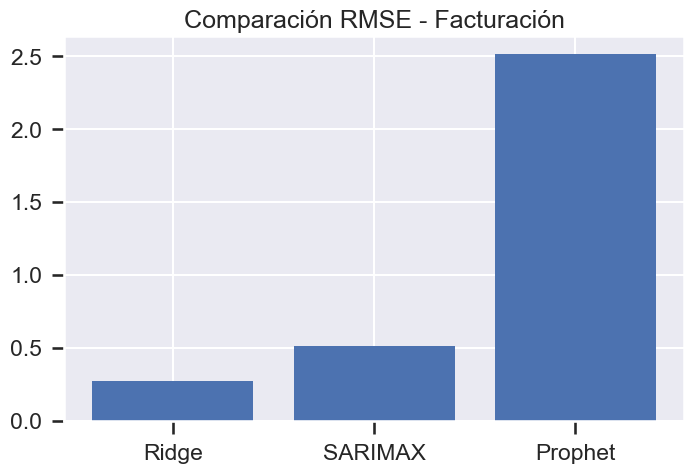

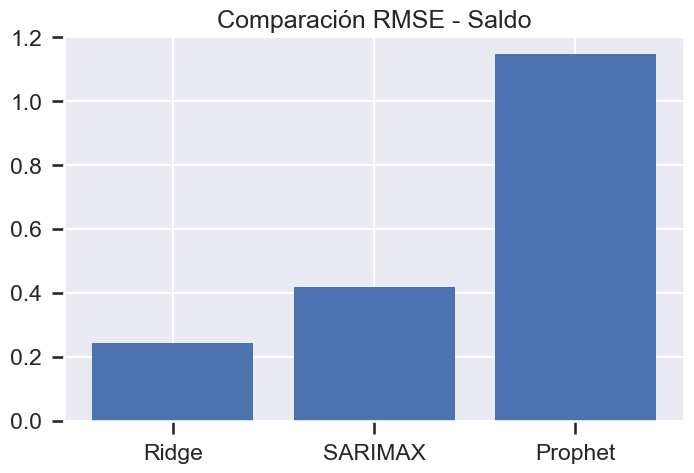


Resultados detallados por fold:
    fold  facturacion_rmse  saldo_rmse
0     1          0.369039    0.150421
1     2          0.269790    0.292992
2     3          0.055224    0.242055


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates

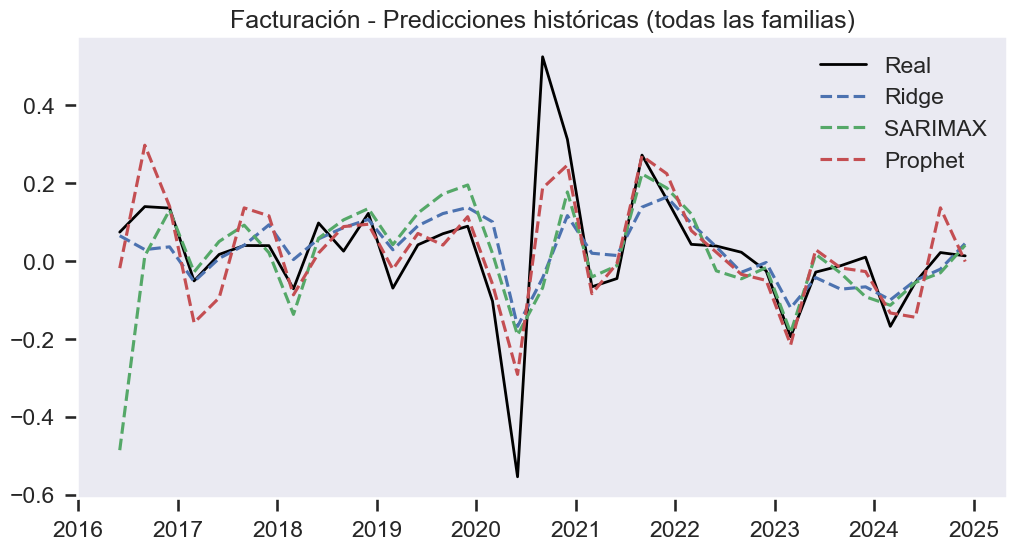

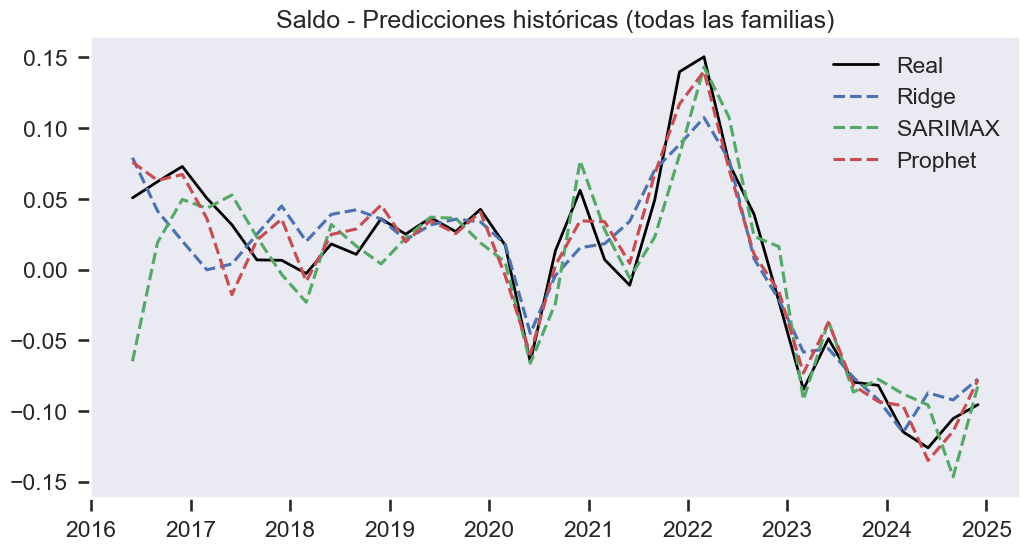

c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates


Modelos finales entrenados y listos para guardar o usar.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# ===============================
# 1. Cargar datos
# ===============================
df = pd.merge(macros, base, left_on='Fecha', right_index=True, how='inner')
df = df.set_index('Fecha')
df = df.sort_index()

# ===============================
# 2. Crear variables target como cambio porcentual (0-1)
# ===============================
df['facturacion_change'] = df['facturacion'].pct_change(fill_method=None)
df['saldo_change'] = df['saldo'].pct_change(fill_method=None)

# ===============================
# 3. Features y targets
# ===============================

# Selección inicial de columnas (todas excepto las targets originales)
feature_cols = [col for col in df.columns if col not in ['facturacion','saldo','facturacion_change','saldo_change']]
target_cols = ['facturacion_change','saldo_change']

# Filtrar columnas para eliminar escenarios simulados (pesimista, alterno, optimista)
# Esto evita que los modelos aprendan con datos de proyección
escenario_keywords = ['pesimista', 'alterno', 'optimista']
feature_cols = [
    col for col in feature_cols 
    if not any(keyword.lower() in col.lower() for keyword in escenario_keywords)
]

# Eliminamos filas con NaN para entrenar modelos (sin fillna)
data = df.dropna(subset=feature_cols + target_cols)

# Definimos los sets finales
X = data[feature_cols]
y_fact = data['facturacion_change']
y_saldo = data['saldo_change']

# ===============================
# Escalado de features y targets
# ===============================
scaler_X = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)

scaler_target_fact = MinMaxScaler()
scaler_target_saldo = MinMaxScaler()

y_fact_scaled = scaler_target_fact.fit_transform(y_fact.values.reshape(-1,1)).ravel()
y_saldo_scaled = scaler_target_saldo.fit_transform(y_saldo.values.reshape(-1,1)).ravel()

# ===============================
# Configuración validación cruzada
# ===============================
tscv = TimeSeriesSplit(n_splits=3)

# ===============================
# Función para evaluar modelos
# ===============================
def evaluate_model(model, X_data, y_data):
    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        rmse_scores.append(rmse)
    return np.median(rmse_scores)

# ===============================
# 4. Modelos Ridge
# ===============================
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

rmse_fact_ridge = evaluate_model(ridge_pipeline, X_scaled, y_fact_scaled)
rmse_saldo_ridge = evaluate_model(ridge_pipeline, X_scaled, y_saldo_scaled)

# ===============================
# 5. SARIMAX (con índice alineado)
# ===============================
def train_sarimax(endog, exog, order):
    endog.index = pd.to_datetime(endog.index)
    exog.index = pd.to_datetime(exog.index)
    model = SARIMAX(endog, order=order, exog=exog,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    return model.fit(disp=False)

def sarimax_cv(order, y_scaled):
    rmse_scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        # Crear series alineadas
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])

        exog_train = X_scaled.iloc[train_idx].copy()
        exog_test = X_scaled.iloc[test_idx].copy()
        exog_train.index = fechas[train_idx]
        exog_test.index = fechas[test_idx]

        model = train_sarimax(y_train, exog_train, order)
        pred = model.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, pred)))

    return np.median(rmse_scores)

order = (1,0,1)
rmse_fact_sarimax = sarimax_cv(order, y_fact_scaled)
rmse_saldo_sarimax = sarimax_cv(order, y_saldo_scaled)

# ===============================
# 6. Prophet
# ===============================
def prepare_prophet_data(target_series, regressors):
    df_prophet = pd.DataFrame({
        'ds': target_series.index,
        'y': target_series.values
    })
    for col in regressors.columns:
        df_prophet[col] = regressors[col].values
    return df_prophet

def prophet_cv(y_scaled):
    rmse_scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]

        df_p = prepare_prophet_data(y_train, exog_train)
        prophet = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)

        future = prepare_prophet_data(y_test, exog_test)
        forecast = prophet.predict(future)
        preds = forecast['yhat'].values
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

    return np.median(rmse_scores)

rmse_fact_prophet = prophet_cv(y_fact_scaled)
rmse_saldo_prophet = prophet_cv(y_saldo_scaled)

# ===============================
# 7. Comparación de resultados
# ===============================
results_fact = pd.DataFrame({
    'Model': ['Ridge','SARIMAX','Prophet'],
    'RMSE': [rmse_fact_ridge, rmse_fact_sarimax, rmse_fact_prophet]
}).sort_values('RMSE')

results_saldo = pd.DataFrame({
    'Model': ['Ridge','SARIMAX','Prophet'],
    'RMSE': [rmse_saldo_ridge, rmse_saldo_sarimax, rmse_saldo_prophet]
}).sort_values('RMSE')

print("Resultados Facturación:\n", results_fact)
print("\nResultados Saldo:\n", results_saldo)

# Seleccionar mejor modelo
best_model_fact = results_fact.iloc[0]
best_model_saldo = results_saldo.iloc[0]
print("\nMejor modelo Facturación:", best_model_fact['Model'])
print("Mejor modelo Saldo:", best_model_saldo['Model'])

# ===============================
# 8. Gráficos de resultados
# ===============================
plt.figure(figsize=(8,5))
plt.bar(results_fact['Model'], results_fact['RMSE'])
plt.title("Comparación RMSE - Facturación")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(results_saldo['Model'], results_saldo['RMSE'])
plt.title("Comparación RMSE - Saldo")
plt.show()

# ===============================
# 9. Guardar métricas por fold para el mejor modelo
# ===============================

# Funciones para obtener RMSE por fold sin cambiar la lógica original
def evaluate_model_folds(model, X_data, y_data):
    scores = []
    for train_idx, test_idx in tscv.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    return scores

def sarimax_folds(order, y_scaled):
    scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]
        model = train_sarimax(y_train, exog_train, order)
        pred = model.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)
        scores.append(np.sqrt(mean_squared_error(y_test, pred)))
    return scores

def prophet_folds(y_scaled):
    scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]
        df_p = prepare_prophet_data(y_train, exog_train)
        prophet = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)
        future = prepare_prophet_data(y_test, exog_test)
        forecast = prophet.predict(future)
        preds = forecast['yhat'].values
        scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    return scores

# Diccionario para almacenar los resultados completos
fold_results = {}

# Resultados por fold para Facturación
if best_model_fact['Model'] == 'Ridge':
    fold_results['facturacion'] = evaluate_model_folds(ridge_pipeline, X_scaled, y_fact_scaled)
elif best_model_fact['Model'] == 'SARIMAX':
    fold_results['facturacion'] = sarimax_folds(order, y_fact_scaled)
else:
    fold_results['facturacion'] = prophet_folds(y_fact_scaled)

# Resultados por fold para Saldo
if best_model_saldo['Model'] == 'Ridge':
    fold_results['saldo'] = evaluate_model_folds(ridge_pipeline, X_scaled, y_saldo_scaled)
elif best_model_saldo['Model'] == 'SARIMAX':
    fold_results['saldo'] = sarimax_folds(order, y_saldo_scaled)
else:
    fold_results['saldo'] = prophet_folds(y_saldo_scaled)

# Guardar en dataframe
df_folds = pd.DataFrame(dict([
    ('fold', list(range(1, len(fold_results['facturacion'])+1))),
    ('facturacion_rmse', fold_results['facturacion']),
    ('saldo_rmse', fold_results['saldo'])
]))
print("\nResultados detallados por fold:\n", df_folds)


# ===============================
# 10. Entrenar los mejores modelos con TODO el histórico y predecir
# ===============================
# Predicciones históricas (solo los datos de entrenamiento)
def predict_best_model(best_model_name, y_scaled):
    if best_model_name == 'Ridge':
        model = Ridge(alpha=1.0)
        model.fit(X_scaled, y_scaled)
        return model.predict(X_scaled)
    elif best_model_name == 'SARIMAX':
        y_series = pd.Series(y_scaled, index=X_scaled.index)
        model = train_sarimax(y_series, X_scaled, order)
        return model.predict(start=X_scaled.index[0], end=X_scaled.index[-1], exog=X_scaled)
    else:  # Prophet
        y_series = pd.Series(y_scaled, index=X_scaled.index)
        df_p = prepare_prophet_data(y_series, X_scaled)
        prophet = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)
        forecast = prophet.predict(df_p)
        return forecast['yhat'].values

# Predicciones en escala original
preds_fact_scaled = predict_best_model(best_model_fact['Model'], y_fact_scaled)
preds_saldo_scaled = predict_best_model(best_model_saldo['Model'], y_saldo_scaled)

preds_fact = scaler_target_fact.inverse_transform(preds_fact_scaled.reshape(-1, 1)).ravel()
preds_saldo = scaler_target_saldo.inverse_transform(preds_saldo_scaled.reshape(-1, 1)).ravel()

# ===============================
# 11. Graficar predicciones históricas PARA TODAS LAS FAMILIAS
# ===============================

# Generar predicciones para TODAS las familias usando todo el histórico
preds_fact_ridge_all = predict_best_model('Ridge', y_fact_scaled)
preds_fact_sarimax_all = predict_best_model('SARIMAX', y_fact_scaled)
preds_fact_prophet_all = predict_best_model('Prophet', y_fact_scaled)

preds_saldo_ridge_all = predict_best_model('Ridge', y_saldo_scaled)
preds_saldo_sarimax_all = predict_best_model('SARIMAX', y_saldo_scaled)
preds_saldo_prophet_all = predict_best_model('Prophet', y_saldo_scaled)

def to_array(preds):
    # Convierte Series o listas a numpy array
    if isinstance(preds, pd.Series):
        return preds.values
    return np.asarray(preds)

# Convertir todo a arrays antes de inverse_transform
preds_fact_ridge_all = to_array(preds_fact_ridge_all)
preds_fact_sarimax_all = to_array(preds_fact_sarimax_all)
preds_fact_prophet_all = to_array(preds_fact_prophet_all)

preds_saldo_ridge_all = to_array(preds_saldo_ridge_all)
preds_saldo_sarimax_all = to_array(preds_saldo_sarimax_all)
preds_saldo_prophet_all = to_array(preds_saldo_prophet_all)

# Invertir escalado
preds_fact_ridge_all = scaler_target_fact.inverse_transform(preds_fact_ridge_all.reshape(-1, 1)).ravel()
preds_fact_sarimax_all = scaler_target_fact.inverse_transform(preds_fact_sarimax_all.reshape(-1, 1)).ravel()
preds_fact_prophet_all = scaler_target_fact.inverse_transform(preds_fact_prophet_all.reshape(-1, 1)).ravel()

preds_saldo_ridge_all = scaler_target_saldo.inverse_transform(preds_saldo_ridge_all.reshape(-1, 1)).ravel()
preds_saldo_sarimax_all = scaler_target_saldo.inverse_transform(preds_saldo_sarimax_all.reshape(-1, 1)).ravel()
preds_saldo_prophet_all = scaler_target_saldo.inverse_transform(preds_saldo_prophet_all.reshape(-1, 1)).ravel()


# Plot para Facturación
plt.figure(figsize=(12, 6))
plt.plot(y_fact.index, y_fact, label='Real', linewidth=2, color='black')
plt.plot(y_fact.index, preds_fact_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_fact.index, preds_fact_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_fact.index, preds_fact_prophet_all, label="Prophet", linestyle='--')
plt.title('Facturación - Predicciones históricas (todas las familias)')
plt.legend()
plt.grid()
plt.show()

# Plot para Saldo
plt.figure(figsize=(12, 6))
plt.plot(y_saldo.index, y_saldo, label='Real', linewidth=2, color='black')
plt.plot(y_saldo.index, preds_saldo_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_prophet_all, label="Prophet", linestyle='--')
plt.title('Saldo - Predicciones históricas (todas las familias)')
plt.legend()
plt.grid()
plt.show()

# =====================================================
# 12. Definición y entrenamiento de los modelos finales
# =====================================================

# ----- FACTURACIÓN -----
# RIGDE final
ridge_final_fact = Ridge(alpha=1.0)
ridge_final_fact.fit(X_scaled, y_fact_scaled)

# SARIMAX final
y_series_fact = pd.Series(y_fact_scaled, index=X_scaled.index)
sarimax_final_fact = train_sarimax(y_series_fact, X_scaled, order)

# PROPHET final
df_p_fact = prepare_prophet_data(y_series_fact, X_scaled)
prophet_final_fact = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True
)
for col in X_scaled.columns:
    prophet_final_fact.add_regressor(col)
prophet_final_fact.fit(df_p_fact)

# ----- SALDO -----
# RIGDE final
ridge_final_saldo = Ridge(alpha=1.0)
ridge_final_saldo.fit(X_scaled, y_saldo_scaled)

# SARIMAX final
y_series_saldo = pd.Series(y_saldo_scaled, index=X_scaled.index)
sarimax_final_saldo = train_sarimax(y_series_saldo, X_scaled, order)

# PROPHET final
df_p_saldo = prepare_prophet_data(y_series_saldo, X_scaled)
prophet_final_saldo = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True
)
for col in X_scaled.columns:
    prophet_final_saldo.add_regressor(col)
prophet_final_saldo.fit(df_p_saldo)

print("\nModelos finales entrenados y listos para guardar o usar.")

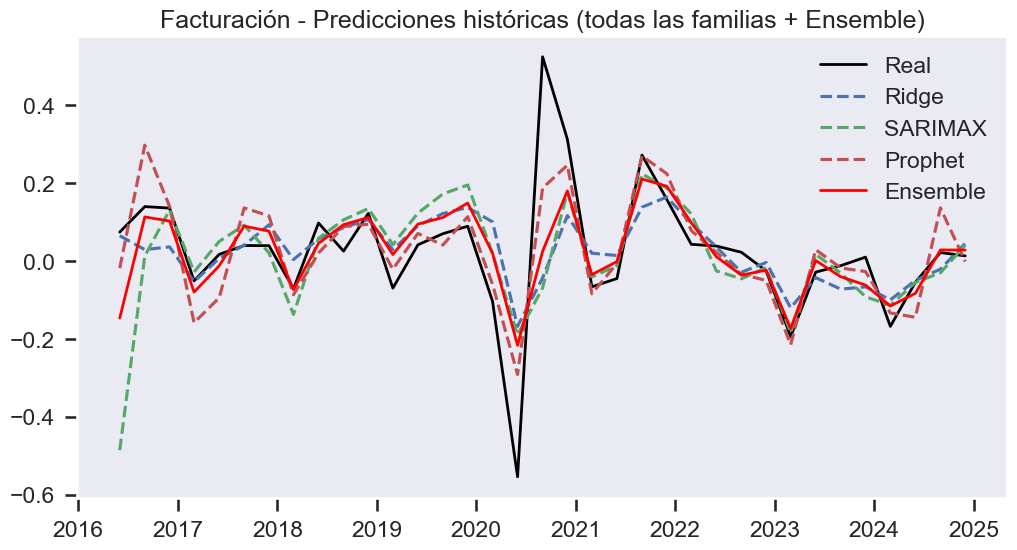

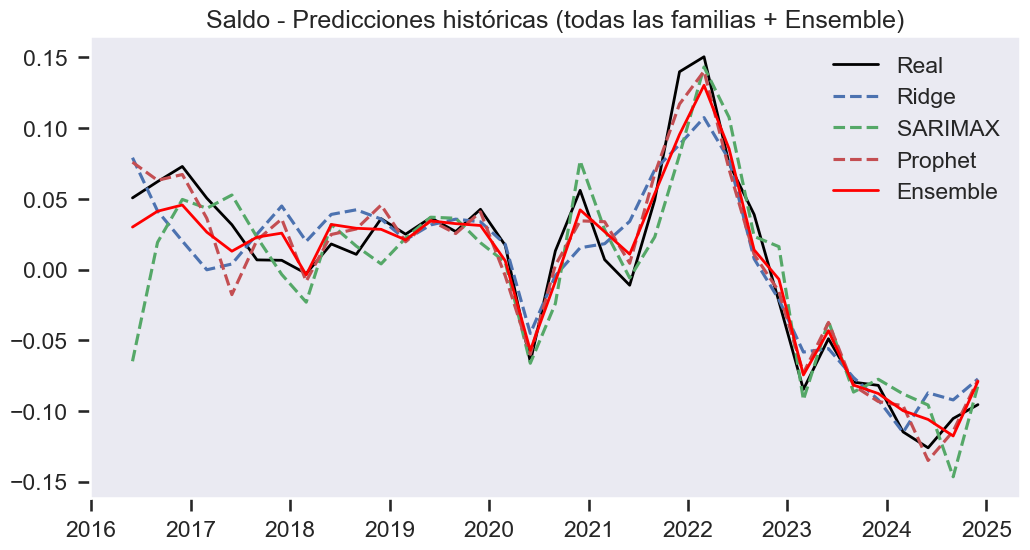

In [4]:
# ===============================
# 12. Ensemble de los tres modelos
# ===============================

# Ensemble como promedio de las 3 predicciones
preds_fact_ensemble_all = (preds_fact_ridge_all + preds_fact_sarimax_all + preds_fact_prophet_all) / 3
preds_saldo_ensemble_all = (preds_saldo_ridge_all + preds_saldo_sarimax_all + preds_saldo_prophet_all) / 3

# Plot para Facturación con ensemble
plt.figure(figsize=(12, 6))
plt.plot(y_fact.index, y_fact, label='Real', linewidth=2, color='black')
plt.plot(y_fact.index, preds_fact_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_fact.index, preds_fact_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_fact.index, preds_fact_prophet_all, label="Prophet", linestyle='--')
plt.plot(y_fact.index, preds_fact_ensemble_all, label="Ensemble", linestyle='-', color='red', linewidth=2)
plt.title('Facturación - Predicciones históricas (todas las familias + Ensemble)')
plt.legend()
plt.grid()
plt.show()

# Plot para Saldo con ensemble
plt.figure(figsize=(12, 6))
plt.plot(y_saldo.index, y_saldo, label='Real', linewidth=2, color='black')
plt.plot(y_saldo.index, preds_saldo_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_prophet_all, label="Prophet", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_ensemble_all, label="Ensemble", linestyle='-', color='red', linewidth=2)
plt.title('Saldo - Predicciones históricas (todas las familias + Ensemble)')
plt.legend()
plt.grid()
plt.show()


## ERROR

In [5]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Función para calcular MAPE (%)
def calcular_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

# Calcular errores para Facturación
errores_fact = {
    "Ridge": calcular_mape(y_fact, preds_fact_ridge_all),
    "SARIMAX": calcular_mape(y_fact, preds_fact_sarimax_all),
    "Prophet": calcular_mape(y_fact, preds_fact_prophet_all),
    "Ensemble": calcular_mape(y_fact, preds_fact_ensemble_all),
}

# Calcular errores para Saldo
errores_saldo = {
    "Ridge": calcular_mape(y_saldo, preds_saldo_ridge_all),
    "SARIMAX": calcular_mape(y_saldo, preds_saldo_sarimax_all),
    "Prophet": calcular_mape(y_saldo, preds_saldo_prophet_all),
    "Ensemble": calcular_mape(y_saldo, preds_saldo_ensemble_all),
}

# Crear DataFrame
df_errores = pd.DataFrame([errores_fact, errores_saldo], index=["Facturación", "Saldo"])
df_errores = df_errores.round(2)  # Redondear a 2 decimales
df_errores


,Ridge,SARIMAX,Prophet,Ensemble
Facturación,118.98,151.01,124.13,106.84
Saldo,104.13,88.30,68.35,61.32


### GUARDANDO EL PIPELINE DE PRONOSTICO EN PKL

In [6]:
import joblib
import numpy as np
import pandas as pd
from prophet import Prophet

class TimeSeriesModelArtifact:
    def __init__(self, ridge_model, sarimax_model, prophet_model,
                 scaler_X, scaler_y, order):
        self.ridge_model = ridge_model
        self.sarimax_model = sarimax_model
        self.prophet_model = prophet_model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.order = order
        # Guardamos los nombres de columnas para asegurar consistencia
        self.feature_columns = None

    def save(self, path):
        joblib.dump(self, path)

    @staticmethod
    def load(path):
        return joblib.load(path)

    def _transform_X(self, X):
        """Escala X usando el scaler entrenado."""
        return pd.DataFrame(
            self.scaler_X.transform(X),
            index=X.index,
            columns=X.columns
        )

    def predict_all(self, X=None, y_history=None):
        """
        Predice usando los 3 modelos (Ridge, SARIMAX, Prophet) y el ensemble.

        Parámetros:
        -----------
        X : pd.DataFrame or None
            Features futuras (exógenas). Si None, usa el set histórico.
        y_history : pd.Series or None
            Serie de tiempo histórica de la variable target escalada
            (necesaria solo si se quiere recalcular Prophet/SARIMAX).
            Para predicciones futuras, se usa internamente la historia original.

        Returns:
        --------
        tuple: (ridge_preds, sarimax_preds, prophet_preds, ensemble_preds)
        """
        # Si X es None, usamos los datos con los que fue entrenado
        if X is None:
            # Backtest
            X_scaled = self.X_scaled_train
            index = self.X_scaled_train.index
        else:
            # Predicción futura
            X_scaled = self._transform_X(X)
            index = X.index

        # ============== Ridge ==============
        ridge_preds = self.ridge_model.predict(X_scaled)
        ridge_preds = self.scaler_y.inverse_transform(
            np.array(ridge_preds).reshape(-1, 1)
        ).ravel()

        # ============== SARIMAX ==============
        if X is None:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        else:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        sarimax_preds = self.scaler_y.inverse_transform(
            np.array(sarimax_preds).reshape(-1, 1)
        ).ravel()

        # ============== Prophet ==============
        if X is None:
            forecast = self.prophet_model.predict(self.df_prophet_train)
            prophet_preds = forecast['yhat'].values
        else:
            future_df = pd.DataFrame({'ds': index})
            for col in X_scaled.columns:
                future_df[col] = X_scaled[col].values
            forecast = self.prophet_model.predict(future_df)
            prophet_preds = forecast['yhat'].values
        prophet_preds = self.scaler_y.inverse_transform(
            np.array(prophet_preds).reshape(-1, 1)
        ).ravel()

        # ============== Ensemble ==============
        ensemble_preds = (ridge_preds + sarimax_preds + prophet_preds) / 3.0

        return ridge_preds, sarimax_preds, prophet_preds, ensemble_preds

    def store_training_data(self, X_scaled_train, df_prophet_train):
        """
        Guarda los datos de entrenamiento procesados para permitir backtesting
        sin necesidad de volver a escalar o preparar datos.
        """
        self.X_scaled_train = X_scaled_train
        self.df_prophet_train = df_prophet_train


In [7]:
# Crear artefacto
artifact_fact = TimeSeriesModelArtifact(
    ridge_model=ridge_final_fact,
    sarimax_model=sarimax_final_fact,
    prophet_model=prophet_final_fact,
    scaler_X=scaler_X,
    scaler_y=scaler_target_fact,
    order=order
)

# Guardar datos escalados y Prophet df
df_p_fact = prepare_prophet_data(
    pd.Series(y_fact_scaled, index=X_scaled.index),
    X_scaled
)
artifact_fact.store_training_data(X_scaled, df_p_fact)

# Guardar artefacto
artifact_fact.save("artifact_fact.pkl")


In [8]:
artifact_saldo = TimeSeriesModelArtifact(
    ridge_model=ridge_final_saldo,
    sarimax_model=sarimax_final_saldo,
    prophet_model=prophet_final_saldo,
    scaler_X=scaler_X,
    scaler_y=scaler_target_saldo,
    order=order
)

# Guardar datos escalados y Prophet df para saldo
df_p_saldo = prepare_prophet_data(
    pd.Series(y_saldo_scaled, index=X_scaled.index),
    X_scaled
)
artifact_saldo.store_training_data(X_scaled, df_p_saldo)

# Guardar artefacto
artifact_saldo.save("artifact_saldo.pkl")
